In [3]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
import sys

sys.path.insert(0, '/Users/Mitch 1/Desktop/Detector_Calibration/Python')
import numpy as np
import uproot 
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,peak_widths,peak_prominences
from scipy import stats
from fit_peak import * 
from pylab import *
from scipy.optimize import curve_fit
import pandas as pd 
from Peak_find import * 
from Calibration_Curve import * 
from Calibration_Equations import *

import time
date_string = time.strftime("%Y-%m-%d-%H:%M")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Detector Calibration 

## The purpose of this notebook is to use python to 'calibrate' the sodium iodide detectors. 

#### When creating a new data run, you need to make sure that you save the data in the "Data" folder in this directory in a folder specific to the detector you are using. For example: You would have a folder in the  

#### 'Data' folder titled: 'Det_65008-01994' Within that folder, you will need to have a folder name speficic to that data run. Example 'Run_07-23-19_Filtered_Data' and store the data in there. Within the same detector 

#### folder, you also need to create a folded titled: 'Figures' All of the figures will automatically save to that folder labeled with the the type of plot, the detector, and the date and time it was created.  

#### Before you start collecting data, double check that the option to save the fitered data as a .root file is selected. Once the data taking procedure is completed, we need to read the .root files into the notebook:  

In [4]:
# For detailed information on how to read and manipulate .root files in python see the documetnation locatied here: https://github.com/scikit
#You will need to change the location of the .root files 

detector = 'Det_65008-01994' #Change for each detector. 

Energy1 = []
# the *.root means read in any file with the .root extension within this folder. 

for arrays in uproot.iterate("~/Desktop/Detector_Calibration/Data/Det_65008-01994/Run_07-23-19_Filtered_Data/*.root","Data_F;1","Energy",outputtype=list):
    
    for x in arrays: # This iterates through every data point 'x' in 'arrays' and stores the data in an array 'Energy1'
        Energy1.extend(x)
        


#### We now need to begin the data fitting procedure. To do so, we need to histogram the data in Energy1 so that it is in a simliar format as it is in COMPASS

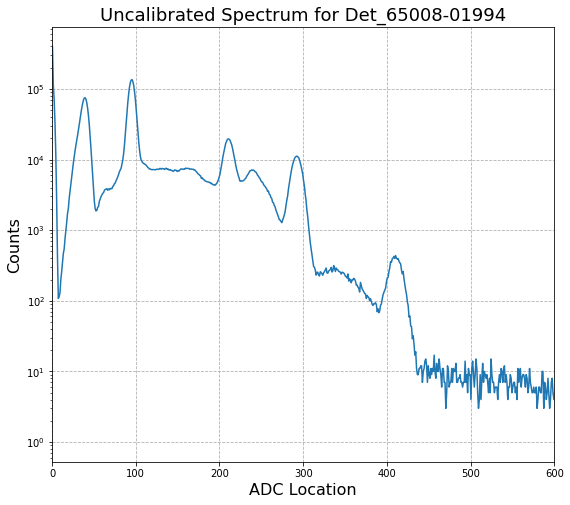

In [5]:
# Histrogram ADC Data 
title = 'Uncalibrated Spectrum for ' +str(detector)
bin = np.arange(0,max(Energy1)) #sets the number of bins 
y,binedges = np.histogram(Energy1,bin) #creates histogram from data
bincenters = 0.5*(binedges[1:]+binedges[:-1]) # calculates location of bin centers based on the edges. 

#confirm that histogram looks right. (compare to images taken from COMPASS)
plt.figure(figsize=(9.0,8.0))
plt.plot(bincenters,y)
plt.xlim(0,600)
plt.yscale('log')
plt.xlabel('ADC Location',size = 16)
plt.ylabel('Counts',size = 16)
plt.title('Uncalibrated Spectrum for '+str(detector),size = 18)
plt.grid(which='major',axis= 'both',linestyle='--')
plt.savefig('Data/'+str(detector)+'/Figures/'+str(title)+' '+str(date_string))

#### Using the histrogramed data, we now need to find the location, amplitude, and width of each on the peaks in ADC. These parameters are what we use to find a calibrated energy spectrum. 

#### Using a peak finding package from scipy.signal:https://docs.scipy.org/doc/scipy/reference/signal.html , we find an initial ADC loctaion, width, and amplitude to use as initial guess in a peak fitting algorithm. 

#### The code to find the inital parameters is located in Peak_find.py. Within Peak_find.py the inital parameters are passed into a peak finding function "fit_peak." The code to fit each peak using the inital guess 

#### parameters is located in fit_peak.py. 


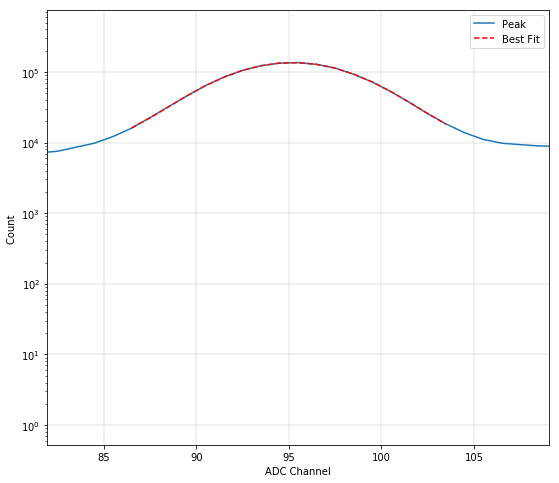

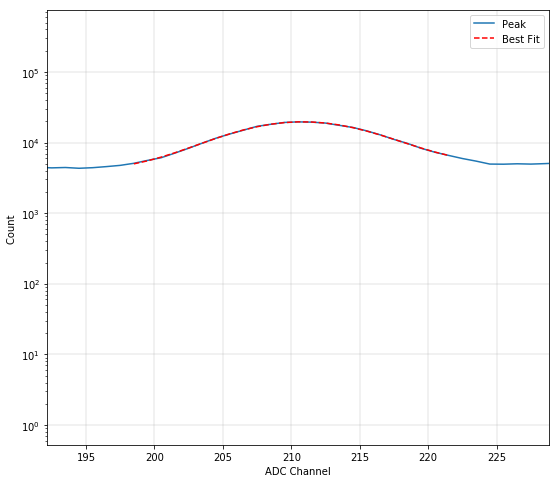

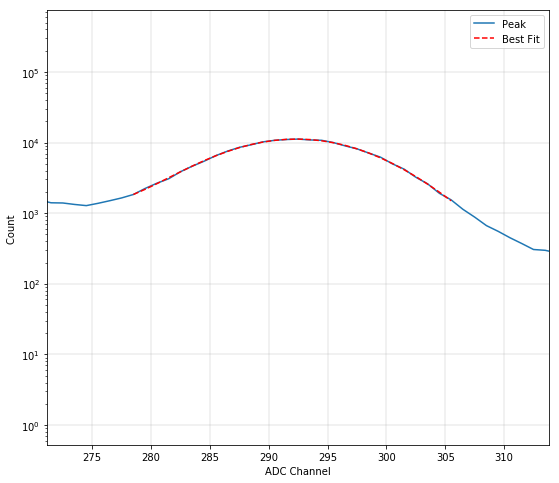

[95.2046363424519, 210.77163240225775, 292.46191029454405]
[95.5, 210.5, 292.5]


In [6]:
# The fucntion 'Peak_locate' is located in 'Peak_find.py'. N represents the number of peaks you wish to fit. This will need to change if you're
# using a source other than Na22, or if you are investigating an unknown peak. 
# The plots below are the results of fitting each peak in ADC. 

# Y = histogrammed data. 
# distance = distance between peaks. Will only look at peaks that are further apart than 'distance' in ADC
# prominance = 'height' of peak. Only looks at peaks with a height greater than 'prominance'
# width = minimum width of peaks to look for. Only looks at peaks with a width greater than 'width'

# The parameters below will need to be adjusted depending on the source you are using. You will need to look at the histogram above to make
# a guess for the parameters. For example, if you wish to fit the last peak, you will need to change N -> 4 and change the prominence to 10**2. 


N = 3 # number of peaks you want to fit. 
distance = 65
prominence =10**3
width = [0,18]

ADC_loc, ADC_fit,peaks,widths,amp,fit,Error = Peak_locate(y,distance,prominence,width,bincenters,N,'ADC')
print(ADC_loc)

# If you are having a hard time fitting all desired peaks. You will need to adjust the parameters in 

## Calibration Curve

#### Now that we have peak locations, we need to transform them into units of keV. We do so by using a calibration curve. A calibration curve allows us to analyze the relationship between a measured quantity and its 

#### physical representation. Here, we look the expected energy peak vs. the location of the peak in ADC. To 'calibrate' the data, we need to preform a linear regression between the expected peak location in units of

#### keV vs the ADC location. The results of the fit are what will be used to 'calibrate.'

In [7]:
# easy way to switch between desitered peaks (depends on N) . You will need to edit this if you want more peaks or use a different sources. 

EN1 = [511,1274,1785] # Na22 peaks 
EN2 = [511,1274,1785,2614] # Na22 peaks + Tl208 peak 
EN3 = [] # Na22 peaks + Barium peaks 

if N ==3: 
    EN = EN1
    
elif N ==4:
    EN = EN2
else: 
    EN = EN3

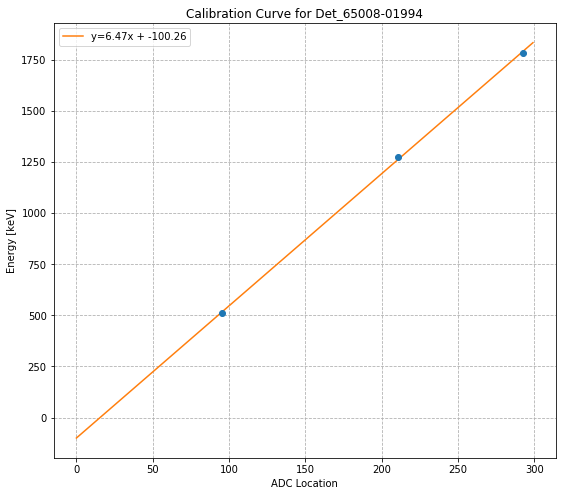

Slope = 6.468113040016105 Intercept = -100.25526316243008 error = 0.09624068950667873


In [8]:
title = 'Calibration Curve for '+str(detector)  

#This will make a plot of expected energy vs. ADC_channel location. This is called a 'Calibration Curve.' Code is located in 'Calibraiton_Curve.py'
slope,intercept,r_value = Calibration_Curve(ADC_fit,ADC_loc,EN,Error,N,title,detector)

#### The slope and inercept of the line of best fit are what we call 'calibration coefficents.' To get a calibrated spectrum we transform the data: 

$CalibratedEnergy = C_1 * ADC + C_0 $

#### Here, $C_1$ is the slope, ADC is the uncalibrated data, and $C_0$ is the intercept from the fit above. You need to record these values in the notebook as '$C_0 = -100.25$' and '$C_1 = 6.47$'


[ 514.21547564 1258.04847524 1788.43374452]


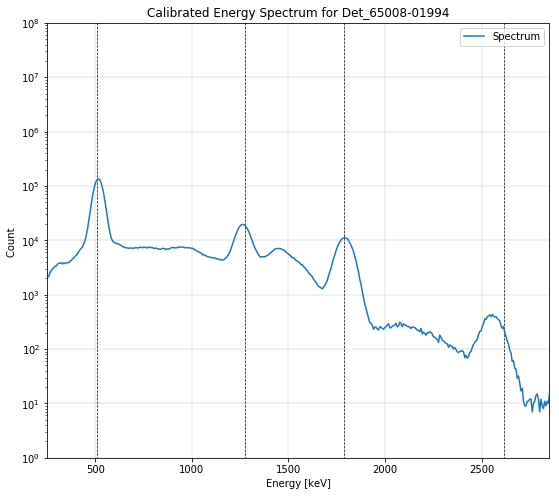

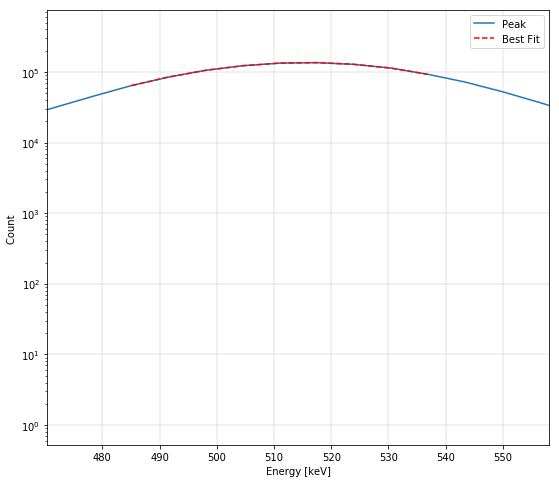

Fit Results for the  511 keV peak
amp = 142444.39 +/- 8826.00
cen = 516.47 +/- 0.44
wid = 25.22 +/- 0.96
slope = -161.71 +/- 76.04
intercept = 76843.69 +/- 31712.03


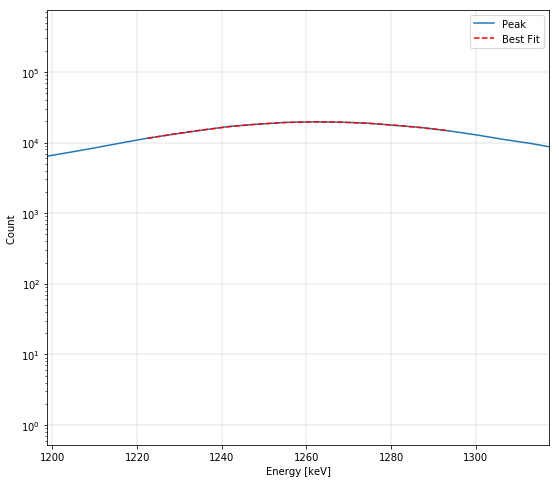

Fit Results for the  1274 keV peak
amp = 12857.10 +/- 1430.97
cen = 1261.23 +/- 0.86
wid = 29.95 +/- 2.33
slope = 22.68 +/- 8.26
intercept = -21791.15 +/- 9659.41


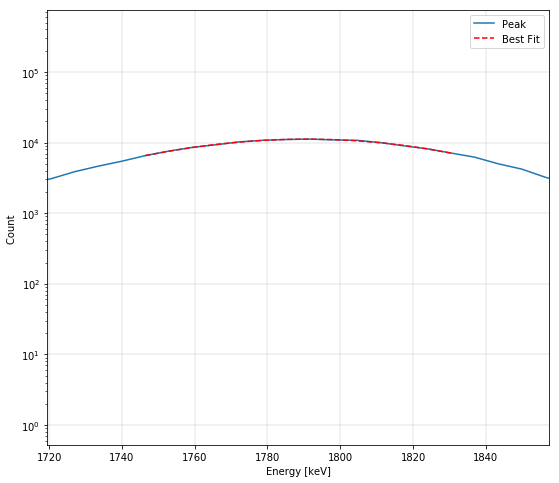

Fit Results for the  1785 keV peak
amp = 10906.10 +/- 2072.98
cen = 1791.74 +/- 1.55
wid = 41.39 +/- 5.02
slope = -6.12 +/- 7.29
intercept = 11256.48 +/- 12111.38


In [9]:

# This function has a few purposes. It takes the uncalibrated data, runs it through the calibration equation and then plots the news spectrum. It then, takes the newly calibrated spectrum and preforms fits in the same manner as before.
# Calibrate_linear is located in "Calibration_Equations.py"



title = 'Calibrated Energy Spectrum for '+str(detector) # change for each detectro

d1,bincenter1,width,mean,amplitude,wid_error = Calibrate_linear(Energy1,ADC_loc,peaks,widths,bin,slope,intercept,'Energy [keV]',title,detector)

# Relative Error in peak Location

#### Relative error is also known as relative uncertainty or approximation error. It is a measure of the uncertainty of measurement compared to the size of the measurement. It's used to put error into perspective.\
#### The relative error is defined as: 
## $$Error = \frac{|X-\hat{X}|}{X}$$
#### Where $X$ is the expected value and $\hat{X}$ is the measured value. 


In [10]:
Mean =[]

for x in mean: 
       m = float("{0:.2f}".format(x))
       Mean.append(m)

print('Expected peak location in Energy is: ',EN)
print('Fitted peak location in Energy is: ',Mean)


for c,e in zip(Mean,EN):

        percent_diff = np.abs(c-e)/(e) * 100
        print('Relative Error in the peak location for ' +str(e)+' is: ',"{0:.2f}".format(percent_diff),'%')

Expected peak location in Energy is:  [511, 1274, 1785]
Fitted peak location in Energy is:  [516.47, 1261.23, 1791.74]
Relative Error in the peak location for 511 is:  1.07 %
Relative Error in the peak location for 1274 is:  1.00 %
Relative Error in the peak location for 1785 is:  0.38 %


# Peak Resolution
#### Peak Resolution refers to the ability to separate two or more objects that are close together in space. A common way to represent the resoultion is through the use of 'Full Width at Half Maximum' or FWHM. 

#### FWHM is the width of a peak at half of its maximum amplitude. For Gaussians, the FWHM is about 2.4 standard deviations. While the concept is simple, this is a vital quantity; the FWHM is used to define resolution.

####  If two peaks have overlapping FWHMs, they are unresolvable, i.e. they will look like one peak.

## $$FWHM = 2\sigma\sqrt{2 ln2}$$

#### For an example, if the $FWHM = 53.4 keV$ at $500 keV$ this would mean that at $500 keV$ we would be able to resolve peaks that were greater than or equal to $53.4 keV$ apart.

#### A common way in which the resolution is reproted is 'Pulse Height Resolution.' PHR is defined as the FWHM divided by the mean energy of the peak of interest. 

## $$PHR = \frac{FWHM}{E_n}$$

In [11]:
for w,e,er in zip(width,EN,wid_error):
        FWHM = 2*w*np.sqrt(np.log(2))
        res = FWHM/(e) * 100 
        print('FWHM for ' +str(e)+ ' keV is: ' ,"{0:.2f}".format(FWHM),'±',"{0:.2f}".format(er))
        print('Pulse Height Resolution for ' +str(e)+ ' keV is: ' ,"{0:.2f}".format(res),'%')


#%%
print(width)

FWHM for 511 keV is:  41.99 ± 0.96
Pulse Height Resolution for 511 keV is:  8.22 %
FWHM for 1274 keV is:  49.88 ± 2.33
Pulse Height Resolution for 1274 keV is:  3.91 %
FWHM for 1785 keV is:  68.92 ± 5.02
Pulse Height Resolution for 1785 keV is:  3.86 %
[25.219860032394394, 29.954218298159358, 41.392967716727526]
